## __LSTM IMPLEMENTATION__<hr>

### Import Libraries<hr>
We will use *pandas* and *numpy* for data manipulation, *nltk* for NLP, *matplotlib*, *seaborn*, and *plotly* for data visualization, *sklearn* and *keras* for training the model.

In [770]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline

### Load the dataset<hr>
We note that we have 500 entries for twitter (tweets) and facebook (posts and commments).

In [771]:
twitter = pd.read_csv('../data/twitter.csv', usecols=[3,4])
facebook = pd.read_csv('../data/facebook.csv', usecols=[3,4])
df = pd.concat([twitter, facebook])
df.head()

,Clean_Translated,Tag
0,Hahahahahhaha happiest day of my life. You hav...,1
1,I like the chocolate bars and then you are thi...,0
2,Hey. You're cute,0
3,I save on going to the massage spa because I h...,0
4,Pretending we know things,0


### Data Analysis - Statistics
In the next 2 cells, we examine the shape of our dataset and check if there are some missing values.

In [772]:
print(twitter.shape)
print(facebook.shape)
print(df.shape)

(824, 2)
(501, 2)
(1325, 2)


we check for missing values using __isna()__:

In [773]:
# No missing values
twitter[twitter.isna().any(axis=1)]
facebook[facebook.isna().any(axis=1)]
df[df.isna().any(axis=1)]

,Clean_Translated,Tag


### Statistic<hr>
We note that we have 500 entries for twitter (tweets) and facebook (posts and commments).

length of all sentences in dataset and statistic:

In [774]:
lens = df['Clean_Translated'].str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

59.350188679245285 44.03167213948862 4 269


Distribution of tweets and post length:

In [775]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
layout = go.Layout(
                  title='Length of tweets and post distribution',                  
                  xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),
                  bargap=0.1)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='length histogram')

Correlate length and sentiment marks:

In [776]:
df['Text_Length'] = df['Clean_Translated'].apply(lambda x: len(x))
data = df.sort_values(by='Text_Length')
plot = go.Scatter(x = data['Text_Length'], y = data['Tag'], mode='markers')
lyt = go.Layout(title="Length vs. Sentiment Label", xaxis=dict(title='Review Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)
py.iplot(fig)

Pearson correlation:

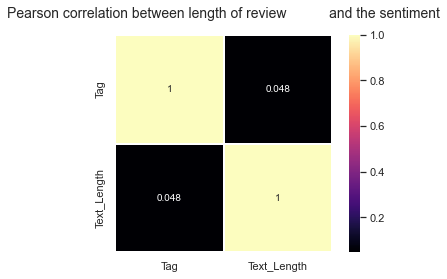

In [777]:
colormap = plt.cm.magma
plt.title('Pearson correlation between length of review\
           and the sentiment', y=1.05, size=14)
sns.heatmap(data.drop(['Clean_Translated'], axis=1).astype(float).corr(),
            linewidths=0.01,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)
plt.show()

#### Commonly seen words in one tag:

In [778]:
df_neg = df[ df['Tag'] == 1]
df_neg = df_neg['Clean_Translated']
df_pos = df[ df['Tag'] == 0]
df_pos = df_pos['Clean_Translated']

>Commonly seen in "__Negative__" sentences

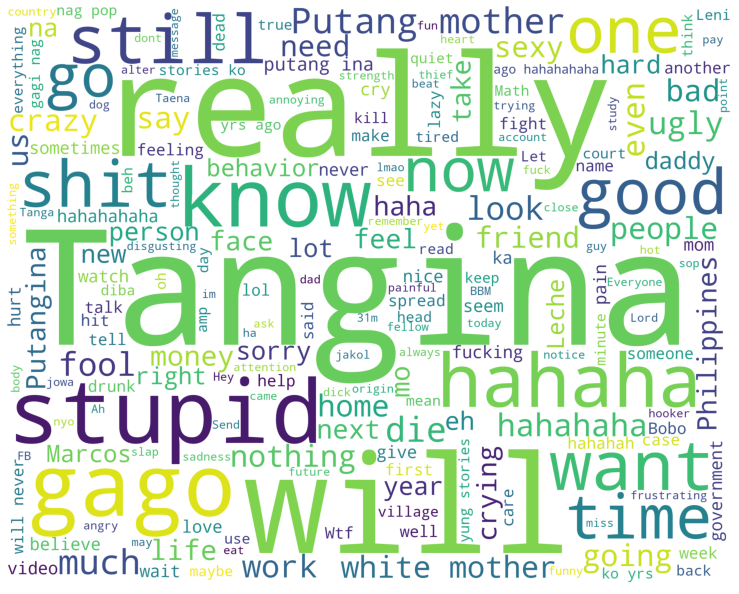

In [779]:
wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

>Commonly seen in "__Positive__" sentences

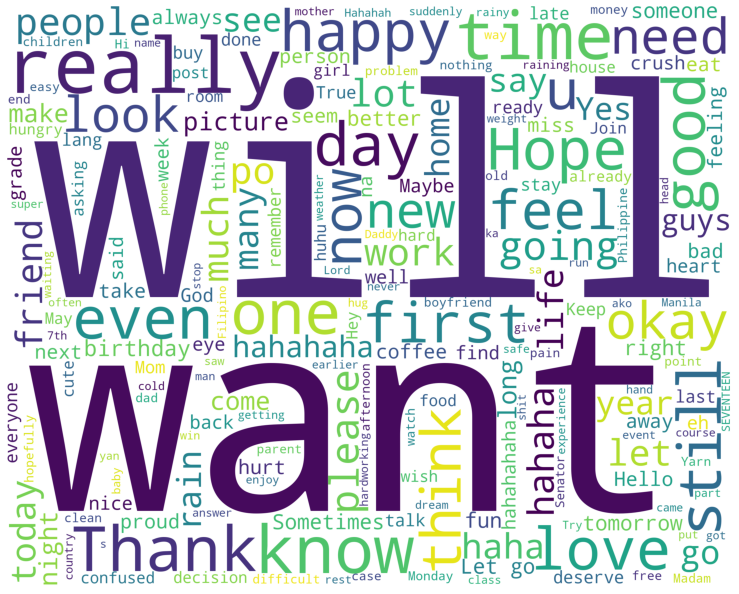

In [780]:
wordcloud2 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))
plt.figure(2,figsize=(13, 13))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

#### Distribution of Sentiments:
In the next 2 cells, we examine the shape of our dataset and check if there are some missing values.

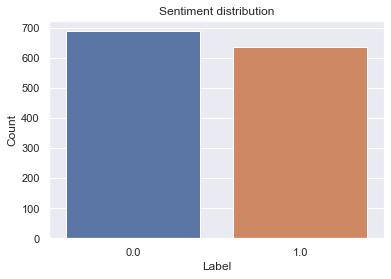

In [781]:
sns.set(style="darkgrid")
b = sns.countplot(x='Tag',
                  data = df.drop(['Clean_Translated'], axis=1).astype(float))
b.axes.set_title('Sentiment distribution')
b.set_xlabel("Label")
b.set_ylabel("Count")
plt.show()

### Text Preprocessing<hr>
Cleaning the text to remove punctuations, transform to lower case, remove emojis, remove hashtags, remove tags, and remove links:

In [782]:
df['Clean_Translated'] = df['Clean_Translated'].apply(prep.simplify_text)
df.head()

,Clean_Translated,Tag,Text_Length
0,hahahahahhaha happiest day of my life you have...,1,187
1,i like the chocolate bars and then you are thi...,0,94
2,hey youre cute,0,16
3,i save on going to the massage spa because i h...,0,93
4,pretending we know things,0,25


Split for training and testing:

In [783]:
text = df['Clean_Translated']
tag = df['Tag']
text_train, text_test, tag_train, tag_test = train_test_split(text, tag, test_size=0.2)
print(text_train.shape,text_test.shape)

(1060,) (265,)


### Naive Bayes - Training the Model<hr>
We use parameter $\text{min}_{\text{df}} = 2$ to filter out words that occur only once in the entire dataset.

In [784]:
vectorizer = TfidfVectorizer(min_df=2)
train_term = vectorizer.fit_transform(text_train)
test_term = vectorizer.transform(text_test)

Check words that will be used by the models as features:

In [785]:
vectorizer.get_feature_names_out()[:5]

array(['169cm', '17', '18', '1st', '2016'], dtype=object)

We could then train the Naive Bayes Model:

In [786]:
model = MultinomialNB()
model.fit(train_term, tag_train)
predictions_train = model.predict(train_term)
predictions_test = model.predict(test_term)
print('Train Accuracy:', accuracy_score(tag_train, predictions_train))
print('Test Accuracy:', accuracy_score(tag_test, predictions_test))

Train Accuracy: 0.8726415094339622
Test Accuracy: 0.7094339622641509


### Checking for mistakes in the model<hr>

we use a confusion matrix for visualization.

Confusion matrix, without normalization
[[533  28]
 [107 392]]
Confusion matrix, without normalization
[[105  22]
 [ 55  83]]


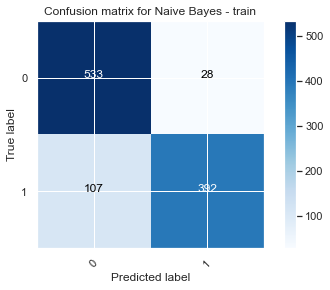

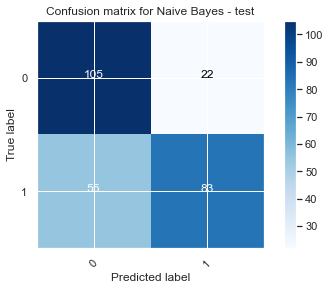

In [787]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix_train = confusion_matrix(tag_train, predictions_train)
cnf_matrix_test = confusion_matrix(tag_test, predictions_test)
plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - test')

### LSTM - Training the Model<hr>
We use Long Short Term Memory Neural Network. We can then use a tokenizer (specifically the one in Keras: note that the other modules may have implementations of tokenizations themselves). We set the maximum feature size to about 2000.

In [809]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Clean_Translated'].values)
text = tokenizer.texts_to_sequences(df['Clean_Translated'].values)
text = pad_sequences(text)

We can then build the model using the Keras library. First, we initialize the sequence model. Then, we add word embedding layer, lstm layer with 16 units and the fully connected (dense) layer with 1 (output) neuron with the sigmoid activation function. We use binary_crossentropy loss and Adam optimizer to train the model.

In [810]:
embed_dim = 64
lstm_out = 16
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=text.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 51, 64)            128000    
                                                                 
 lstm_42 (LSTM)              (None, 16)                5184      
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                                 
Total params: 133,201
Trainable params: 133,201
Non-trainable params: 0
_________________________________________________________________
None


In [811]:
tag = df['Tag'].values

In [812]:
text_train, text_test, tag_train, tag_test = train_test_split(text,tag, test_size = 0.3)
print(text_train.shape,tag_train.shape)
print(text_test.shape,tag_test.shape)

(927, 51) (927,)
(398, 51) (398,)


We train with a batch size of 15 and train for 10 epoch. The performance of the model is measured on the validation dataset.

In [813]:
batch_size = 20
model.fit(text_train,
          tag_train,
          epochs=10,
          batch_size=batch_size,
          validation_data=(text_test, tag_test),
          callbacks = [EarlyStopping(monitor='val_acc',
                       min_delta=0.001,
                       patience=2,
                       verbose=0)]
           )

Epoch 1/10
47/47 [==============================] - 5s 42ms/step - loss: 0.6903 - accuracy: 0.5286 - val_loss: 0.6862 - val_accuracy: 0.5779
Epoch 2/10
47/47 [==============================] - 1s 28ms/step - loss: 0.6512 - accuracy: 0.7271 - val_loss: 0.6617 - val_accuracy: 0.6080
Epoch 3/10
47/47 [==============================] - 1s 31ms/step - loss: 0.4844 - accuracy: 0.8166 - val_loss: 0.5929 - val_accuracy: 0.7060
Epoch 4/10
47/47 [==============================] - 1s 30ms/step - loss: 0.2977 - accuracy: 0.9029 - val_loss: 0.6198 - val_accuracy: 0.7010
Epoch 5/10
47/47 [==============================] - 1s 31ms/step - loss: 0.1892 - accuracy: 0.9428 - val_loss: 0.6772 - val_accuracy: 0.6910
Epoch 6/10
47/47 [==============================] - 2s 33ms/step - loss: 0.1315 - accuracy: 0.9709 - val_loss: 0.7409 - val_accuracy: 0.7035
Epoch 7/10
47/47 [==============================] - 1s 29ms/step - loss: 0.1019 - accuracy: 0.9730 - val_loss: 0.7653 - val_accuracy: 0.7035
Epoch 8/10
47

In [814]:
predictions_nn_train = model.predict(text_train)
predictions_nn_test = model.predict(text_test)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1
print('Train accuracy:', accuracy_score(tag_train, predictions_nn_train))
print('Test accuracy', accuracy_score(tag_test, predictions_nn_test))

13/13 [==============================] - 0s 7ms/step
Train accuracy: 0.9892125134843581
Test accuracy 0.7010050251256281


Check the confusion matrix: